<a href="https://colab.research.google.com/github/oilnutttt/bsc_dpdm22/blob/main/midterm_dpdm22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import json
import numpy as np
import geopy.distance
from sklearn.metrics import mean_absolute_percentage_error as mape #mape

In [2]:
import gspread as gs
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [4]:
import os
os.chdir('/content/gdrive/MyDrive/mtbsc')

!pwd #เช็ค paht ที่กำลังทำงานอยู่

/content/gdrive/MyDrive/mtbsc


## การเตรียมข้อมูลประกอบด้วย กำจัด outlier, แก้ missing, normalization, one-hot-encoder และ อื่นๆ ที่นักศึกษาเห็นว่าเหมาะสม

# 1 ทำนายราคาบ้าน 10 คะแนน
เตรียมข้อมูลเพื่อทำนายราคาบ้าน ราคาประเมินบ้าน และ คะแนนทรัพย์ จาก [google drive](https://drive.google.com/drive/folders/1uIcUFY1yldIq-A3wijh2n2N6az-EljIe?usp=sharing) โดยข้อมูลที่เตรียมต้องประกอบด้วย columns ต่อไปนี้

* ```'renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price'``` จากตาราง "คำตอบนักประเมิน(ID)"

* ```จำนวน 7-11 และ โรงเรียน ในรัศมี 200,500,1000,2000 เมตร (ตั้งชื่อ d200-7/11','d500-7/11',...,'d2000-7/11' แบะ ;d200-school','d500-school',...,'d2000-school')``` จากตาราง "7-eleven.json" และ "school.json"

* ```ประเมินราคาซื้อขาย และ คะแนนทรัพย์ (ตั้งชื่อ 'estimator' และ 'score')``` จากตาราง คำตอบนักประเมิน(ID) โดยราคาประเมินกับคะแนนทรัพย์ อ้างอิงของนักประเมิน ID=01 คนเดียว

## Data House

In [5]:
link1 = 'https://docs.google.com/spreadsheets/d/1YyuATF79TZqDy_FY9VR-6HG04IhSJCZ7Ni2uZz57Oos/export?format=xlsx'

In [6]:
house_data1 = pd.read_excel(link1,sheet_name='บ้านมือ1')
house_data2 = pd.read_excel(link1,sheet_name='บ้านมือ2')

In [7]:
#for i in house_data1.columns:
 #   print(i)

house_data1 ไม่มี renovate

เลยเติม column renovate เข้าไป โดยข้อมูลใน renovate ทั้งหมดเป็น no เพราะบ้านมือ 1 จะไม่มีการ renovate อยู่แล้ว

เพิ่ม column second_hand เพื่อบอกว่าเป็นบ้านมือ 1 หรือ มือ 2 
- 1 คือ บ้านมือ 1
- 2 คือ บ้านมือ 2

In [8]:
house_data1 = house_data1[['id','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price','latitude','longitude']]

In [9]:
house_data1['renovate'] = 'no'
house_data1['second_hand'] = 1

<ipython-input-9-2543ac22e927>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_data1['renovate'] = 'no'
<ipython-input-9-2543ac22e927>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_data1['second_hand'] = 1


In [10]:
house_data1.shape

(754, 16)

In [11]:
house_data2 = house_data2[['id','renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price','latitude','longitude']]

In [12]:
house_data2['second_hand'] = 2

In [13]:
house_data2.shape

(1656, 16)

In [14]:
house_data = pd.concat([house_data1,house_data2])
print(house_data.shape)
house_data.head(3)

(2410, 16)


,id,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,latitude,longitude,renovate,second_hand
0,314.0,NaN,NaN,50.00,2.0,4.0,3.0,0.0,0.0,185.0,2.0,3950000.0,16.392304,102.827926,no,1
1,315.0,NaN,NaN,40.00,2.0,4.0,3.0,0.0,0.0,165.0,2.0,3250000.0,16.392304,102.827926,no,1
2,316.0,NaN,NaN,77.25,2.0,4.0,3.0,0.0,0.0,260.0,2.0,6300000.0,16.392304,102.827926,no,1


rai all
ngan all
va 92
story 4
bedroom 10
bath 10
direction 88
fur 88
usable area 36
parking 21
sell 21

หา latitude ที่มากกว่า 90 แล้ว drop เพราะ ค่า latitude ควรอยู่ในช่วง [-90,90]

In [15]:
latmt90 = house_data[house_data['latitude'] >90].index

In [16]:
house_data = house_data.drop(latmt90)

In [17]:
house_data.isnull().any()

id                    False
number_of_rai          True
number_of_ngan         True
number_of_va           True
number_of_story        True
number_of_bedroom      True
number_of_bathroom     True
direction             False
furniture             False
usable_area            True
number_of_parking      True
sell_price             True
latitude               True
longitude              True
renovate               True
second_hand           False
dtype: bool

In [18]:
house_data.shape

(2221, 16)

### drop

latitude or longitude

In [19]:
print(len(house_data[house_data['latitude' or 'longitude'].isnull()])) 
#house_data[house_data['sell_price'].isnull()]

30


In [20]:
house_data = house_data.dropna(subset=['latitude', 'longitude'])

sell price

In [21]:
print(len(house_data[house_data['sell_price'].isnull()])) 
#house_data[house_data['sell_price'].isnull()]

6


In [22]:
house_data = house_data.dropna(subset=['sell_price'])

ลบ missing ที่ตรงกัน ของ ไร่ งาน วา 

In [23]:
house_data.fillna({'number_of_rai':0, 'number_of_ngan':0, 'number_of_va':0}, inplace=True)

In [24]:
null = house_data[house_data['number_of_rai' and 'number_of_ngan' and 'number_of_va']==0].index

In [25]:
house_data = house_data.drop(null)

In [26]:
house_data.shape

(1934, 16)

### fillna

number_of_parking

In [27]:
print(len(house_data[house_data['number_of_parking'].isnull()])) 
#house_data[house_data['renovate'].isnull()]

121


renovate

In [28]:
print(len(house_data[house_data['renovate'].isnull()])) 
#house_data[house_data['renovate'].isnull()]

97


In [29]:
house_data.fillna({'renovate':'Unknow'}, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


เปลี่ยนคำว่า ไม่ระบุ เป็น Unknow

In [30]:
house_data['renovate'] = house_data['renovate'].replace(['ไม่ระบุ'], ['Unknow'])

number_of_story

In [31]:
print(len(house_data[house_data['number_of_story'].isnull()])) 
#house_data[house_data['renovate'].isnull()]

437


number_of_bedroom

In [32]:
print(len(house_data[house_data['number_of_bedroom'].isnull()])) 
#house_data[house_data['number_of_bedroom'].isnull()]

16


In [33]:
house_data.fillna({'number_of_story':0, 'number_of_bedroom':1 ,'usable_area':0, 'number_of_parking':0}, inplace=True)

## 7-eleven and school

In [34]:
with open('/content/gdrive/MyDrive/mtbsc/7-eleven.json') as json_file:
    seven = json.loads(json_file.read())

In [35]:
with open('/content/gdrive/MyDrive/mtbsc/school.json') as json_file:
    school = json.loads(json_file.read())

In [36]:
id = 25

In [37]:
this_home = house_data[house_data['id']== id]
this_home

,id,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,latitude,longitude,renovate,second_hand
7,25.0,0.0,0.0,63.8,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,135.0,1.0,2700000.0,16.410179,102.857613,no,2


In [38]:
h_lat=this_home['latitude'].values[0]
h_long=this_home['longitude'].values[0]

In [39]:
seven_id = {}
for t in seven:
    l = list()
    for x in seven[t]:
        l.append(x['geometry']['location'])
    print(t) #id
    print(l)
    seven_id[t] = l #สร้างdict (สมาชิก t คือ list l)

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
6284
[]
6285
[{'lat': 16.3280289, 'lng': 102.8466104}]
6286
[]
6289
[]
6290
[]
6291
[{'lat': 16.760925, 'lng': 102.6348166}]
6292
[{'lat': 16.3280289, 'lng': 102.8466104}]
6296
[{'lat': 16.5219606, 'lng': 102.219816}]
6297
[]
6298
[{'lat': 16.4501543, 'lng': 102.7382279}, {'lat': 16.4481776, 'lng': 102.7736213}, {'lat': 16.4496233, 'lng': 102.7578029}, {'lat': 16.4512684, 'lng': 102.7517798}]
6302
[]
6306
[]
6310
[]
6311
[]
6313
[{'lat': 16.4506978, 'lng': 102.7955315}, {'lat': 16.4786388, 'lng': 102.814293}, {'lat': 16.4794698, 'lng': 102.8070934}, {'lat': 16.4423, 'lng': 102.808299}, {'lat': 16.4802561, 'lng': 102.8118345}, {'lat': 16.4800345, 'lng': 102.817991}, {'lat': 16.4800801, 'lng': 102.8157501}, {'lat': 16.4421359, 'lng': 102.8198991}, {'lat': 16.4781927, 'lng': 102.8199828}, {'lat': 16.4463944, 'lng': 102.8200097}]
6316
[]
6319
[{'lat': 16.7035329, 'lng': 103.0785806}, {'lat': 16.7009297, 'lng': 103.0838363}, {'lat': 1

In [40]:
this_seven = seven_id[str(id)]

In [41]:
seven_dist=list()
loc1 = [h_lat,h_long]
for seven in this_seven:
    loc2 = [seven['lat'],seven['lng']]
    dist = geopy.distance.geodesic(loc1,loc2).m
    seven_dist.append(dist)

seven_dist

[2026.3410640485051,
 2561.1300438835406,
 1802.022379353695,
 371.3607033942288,
 1362.068179007474,
 2122.0746378621734,
 2033.8379723813946,
 2226.324543949096,
 2028.9546247130654,
 2204.142864576839,
 2057.0874274932844,
 2358.161790753285,
 2078.784658007895,
 2095.8694500771535,
 2415.419008344456,
 2329.134777870196,
 2858.020875919802]

In [42]:
sum(np.array(seven_dist) < 200)

0

In [43]:
school_id = {}
for a in school:
    b = list()
    for y in school[a]:
        b.append(y['geometry']['location'])
    print(t) #id
    print(l)
    school_id[a] = b #สร้างdict (สมาชิก t คือ list l)

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
30362P
[{'lat': 13.7374346, 'lng': 100.6267268}, {'lat': 13.7356967, 'lng': 100.6189741}, {'lat': 13.754974, 'lng': 100.613215}, {'lat': 13.7607113, 'lng': 100.6292369}, {'lat': 13.7568211, 'lng': 100.6445227}, {'lat': 13.7522027, 'lng': 100.6193615}, {'lat': 13.7366139, 'lng': 100.6313462}, {'lat': 13.7367845, 'lng': 100.6241795}, {'lat': 13.7563129, 'lng': 100.6131975}, {'lat': 13.7523059, 'lng': 100.6182354}, {'lat': 13.7519672, 'lng': 100.6357339}, {'lat': 13.7420702, 'lng': 100.6326465}, {'lat': 13.7623488, 'lng': 100.644072}, {'lat': 13.7528219, 'lng': 100.6206503}, {'lat': 13.7609686, 'lng': 100.631794}, {'lat': 13.74039, 'lng': 100.6252888}, {'lat': 13.74231, 'lng': 100.6247883}, {'lat': 13.7602053, 'lng': 100.6220398}, {'lat': 13.7362923, 'lng': 100.6169101}, {'lat': 13.7520004, 'lng': 100.6348106}]
30362P
[{'lat': 13.7374346, 'lng': 100.6267268}, {'lat': 13.7356967, 'lng': 100.6189741}, {'lat': 13.754974, 'lng': 100.613

In [44]:
this_school = school_id[str(id)]

In [45]:
school_dist=list()
loc1 = [h_lat,h_long]
for school in this_school:
    loc3 = [school['lat'],school['lng']]
    dist = geopy.distance.geodesic(loc1,loc3).m
    school_dist.append(dist)

school_dist

[2004.0918545068967,
 2428.2987915685653,
 2038.435849524896,
 2717.652621461165,
 1482.8417616510071,
 1926.415131599258,
 82.13510412222988,
 2215.3515258053017,
 1744.6197787401782,
 2260.7109855845897,
 2717.8019980442086,
 1538.46971795965,
 1873.7358589714045,
 2136.4745799527823]

In [46]:
sum(np.array(school_dist) < 200)

1

In [47]:
record_list = list()   
for id in house_data['id']:
    this_home = house_data[house_data['id']== id]
    h_lat=this_home['latitude'].values[0]
    h_long=this_home['longitude'].values[0]

    if str(id) not in seven_id: #ถ้าไม่มี id บ้าน ไม่ตรงกับ seven id
        seven_id = [] #ให้ seven id เป็น ค่าว่าง
    else :
        this_seven = seven_id[str(id)]
    if str(id) not in school_id: #ถ้าไม่มี id บ้าน ไม่ตรงกับ school id
        school_id = [] #ให้ school id เป็น ค่าว่าง
    else :
        this_school = school_id[str(id)]
    
    seven_dist=list()
    loc1 = [h_lat,h_long]
    for seven in this_seven:
        loc2 = [seven['lat'],seven['lng']]
        dist = geopy.distance.geodesic(loc1,loc2).m
        seven_dist.append(dist)
    school_dist = list() #
    loc1 = [h_lat,h_long]
    for school in this_school:
        loc3 = [school['lat'],school['lng']] #ต้องเปลี่ยนค่า
        dist2 = geopy.distance.geodesic(loc1,loc3).m
        school_dist.append(dist2)
    
    record_dict = {}
    record_dict['id'] = id 
    record_dict['d200-7/11'] = sum(np.array(seven_dist) < 200)
    record_dict['d500-7/11'] = sum(np.array(seven_dist) < 500)
    record_dict['d1000-7/11'] = sum(np.array(seven_dist) < 1000)
    record_dict['d2000-7/11'] = sum(np.array(seven_dist) < 2000)
    record_dict['d200-school'] = sum(np.array(school_dist) < 200) 
    record_dict['d500-school'] = sum(np.array(school_dist) < 500)
    record_dict['d1000-school'] = sum(np.array(school_dist) < 1000)
    record_dict['d2000-school'] = sum(np.array(school_dist) < 2000)
    record_list.append(record_dict)

final_table = pd.DataFrame(record_list)

In [48]:
final_table.head(3)

,id,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school
0,314.0,0,0,0,2,0,0,0,2
1,315.0,0,0,0,2,0,0,0,2
2,316.0,0,0,0,2,0,0,0,2


## คำตอบนักประเมิน

In [49]:
link2 = 'https://docs.google.com/spreadsheets/d/18psSJivNvuH2n1RYvlp2zlr_5QcpzC39QCow5Au3yIc/export?format=xlsx'

In [50]:
est_house = pd.read_excel(link2,sheet_name='บ้าน')

เปลี่ยนชื่อคอลัมน์

In [51]:
est_house.rename(columns={'ID' : 'id', 'ราคาทรัพย์' : 'property_price', 'ประเมินราคาซื้อ-ขาย' : 'estimator', 'ให้คะแนนทรัพย์' : 'score'}, inplace=True)

เลือกคอลัมน์

In [52]:
est_house = est_house[['ID ผู้ประเมิน','id', 'property_price', 'estimator', 'score']]

check ว่าคอลัมน์ score มี ค่าอะไรบ้าง มีเท่าไหร่

In [53]:
est_house['score'].value_counts()

3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน     1319
2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี     330
4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน       130
1 ขายไม่ได้แน่นอน                        3
5 ขายง่าย ใช้ระยะเวลา 1 - 3 เดือน        1
Name: score, dtype: int64

เปลี่ยนคะแนนในคอลัมน์ score ให้เป็นแค่ตัวเลข 1 2 3 4

In [54]:
est_house['score'] = est_house['score'].replace(['1 ขายไม่ได้แน่นอน', '2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี', '3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน', '4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน', '5 ขายง่าย ใช้ระยะเวลา 1 - 3 เดือน']
                                                , [1,2,3,4,5])

เลือกผู้ประเมินคนที่ 1

In [55]:
est1 = est_house[est_house['ID ผู้ประเมิน']==1]

In [56]:
est1.columns

Index(['ID ผู้ประเมิน', 'id', 'property_price', 'estimator', 'score'], dtype='object')

In [57]:
est1.isnull().any() # check missing

ID ผู้ประเมิน     False
id                False
property_price     True
estimator          True
score              True
dtype: bool

In [58]:
print(len(est1[est1['property_price'].isnull()])) # นับจำนวน missing 
est1[est1['property_price'].isnull()] # แสดงmissing

1


,ID ผู้ประเมิน,id,property_price,estimator,score
20,1.0,3063P,NaN,4300000.0,2.0


In [59]:
print(len(est1[est1['estimator'].isnull()])) 
est1[est1['estimator'].isnull()]

1


,ID ผู้ประเมิน,id,property_price,estimator,score
903,1.0,6051.0,2430000.0,NaN,2.0


In [60]:
print(len(est1[est1['score'].isnull()])) 
est1[est1['score'].isnull()]

1


,ID ผู้ประเมิน,id,property_price,estimator,score
283,1.0,10507P,4190000.0,4200000.0,NaN


In [61]:
est1 = est1.dropna(subset=['property_price', 'estimator', 'score']) # drop ออก
est1.shape

(1214, 5)

In [62]:
print(est1.shape)
est1.head(3)

(1214, 5)


,ID ผู้ประเมิน,id,property_price,estimator,score
0,1.0,3099P,4000000.0,3800000.0,2.0
1,1.0,3098P,2990000.0,2500000.0,3.0
2,1.0,3097P,2990000.0,2700000.0,3.0


## รวมตาราง

In [63]:
House = house_data.merge(final_table, how ='inner', left_on='id',right_on='id') 
print(House.shape)
House.head(3)

(1956, 24)


,id,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,...,renovate,second_hand,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school
0,314.0,0.0,0.0,50.00,2.0,4.0,3.0,0.0,0.0,185.0,...,no,1,0,0,0,2,0,0,0,2
1,315.0,0.0,0.0,40.00,2.0,4.0,3.0,0.0,0.0,165.0,...,no,1,0,0,0,2,0,0,0,2
2,316.0,0.0,0.0,77.25,2.0,4.0,3.0,0.0,0.0,260.0,...,no,1,0,0,0,2,0,0,0,2


In [64]:
house_all = House.merge(est1, how ='inner', left_on='id',right_on='id') 
print(house_all.shape)
house_all.head(3)

(1009, 28)


,id,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,...,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school,ID ผู้ประเมิน,property_price,estimator,score
0,1.0,0.0,1.0,45.0,2.0,2.0,2.0,ไม่ระบุ,ไม่มี,244.0,...,0,0,0,0,0,0,1.0,390000.0,600000.0,4.0
1,4.0,0.0,0.0,88.0,1.0,1.0,1.0,ไม่ระบุ,ไม่มี,164.0,...,0,0,0,0,0,0,1.0,930000.0,750000.0,3.0
2,16.0,1.0,0.0,8.0,1.0,11.0,11.0,ไม่ระบุ,ไม่ระบุ,489.0,...,0,0,0,0,0,0,1.0,2994000.0,2800000.0,2.0


## one-hot-encoder

In [65]:
House_dummies = pd.get_dummies(House,columns=['furniture','renovate','second_hand']) 

In [66]:
House_dummies

,id,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,usable_area,number_of_parking,...,furniture_0.0,furniture_ตกแต่งครบ,furniture_มีบางส่วน,furniture_ไม่มี,furniture_ไม่ระบุ,renovate_Unknow,renovate_no,renovate_yes,second_hand_1,second_hand_2
0,314.0,0.0,0.0,50.00,2.0,4.0,3.0,0.0,185.00,2.0,...,1,0,0,0,0,0,1,0,1,0
1,315.0,0.0,0.0,40.00,2.0,4.0,3.0,0.0,165.00,2.0,...,1,0,0,0,0,0,1,0,1,0
2,316.0,0.0,0.0,77.25,2.0,4.0,3.0,0.0,260.00,2.0,...,1,0,0,0,0,0,1,0,1,0
3,317.0,0.0,0.0,81.25,2.0,6.0,5.0,0.0,343.00,3.0,...,1,0,0,0,0,0,1,0,1,0
4,318.0,0.0,0.0,55.00,2.0,4.0,4.0,0.0,223.00,2.0,...,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,30267P,0.0,0.0,64.00,1.0,3.0,2.0,ไม่ระบุ,258.00,0.0,...,0,0,1,0,0,1,0,0,0,1
1952,30278P,0.0,0.0,65.00,2.0,4.0,4.0,ไม่ระบุ,130.00,0.0,...,0,0,0,0,1,1,0,0,0,1
1953,30305P,1.0,1.0,1.00,0.0,1.0,1.0,ไม่ระบุ,2800.00,0.0,...,0,0,0,0,1,1,0,0,0,1
1954,30342P,0.0,3.0,10.00,0.0,4.0,3.0,ไม่ระบุ,213.75,0.0,...,0,0,0,0,1,0,1,0,0,1


# 2 ทำนายสภาพอากาศ 10 คะแนน
เตรียมข้อมูลเพื่อทำนายสภาพอากาศของวันถัดไป โดย 
- กลุ่มที่ 1 และ 9 ทำนาย อุณหภูมิตุ้มแห้ง (Y)
- กลุ่มที่ 2 ทำนาย อุณหภูมิต่ำสุด (Y)
- กลุ่มที่ 3 ทำนาย อุณหภูมิจุดน้ำค้าง (Y)
- กลุ่มที่ 4 ทำนาย จำนวนเมฆ (Y)
- กลุ่มที่ 5 ทำนาย ปริมาณฝน (Y)
- กลุ่มที่ 6 ทำนาย ความชื้นสัมพัทธ์ (Y)
- กลุ่มที่ 7 ทำนาย ความกด (Y)
- กลุ่มที่ 8 ทำนาย ความเร็วลม (Y)

ลักษณะของ data เป็นดังนี้ Xi คือ features อื่นๆที่ใช้ในทำนาย และ Y คือค่าที่ต้องการทำนาย

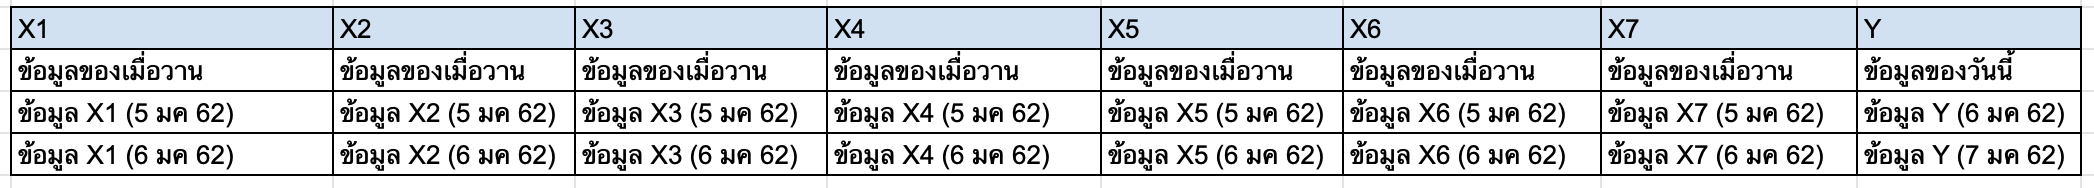



In [68]:
import os
os.chdir('/content/gdrive/MyDrive/mtbsc/อุตุ')

!pwd #เช็ค paht ที่กำลังทำงานอยู่

/content/gdrive/.shortcut-targets-by-id/1k6tJcTTv2bKmFz6A5oOWi-sAeTVIQpG4/อุตุ


## ความกด

In [70]:
#เรียกใช้ไฟล์ เปลี่ยนชื่อ เก็บในตัวแปร

akkn = pd.read_excel('ความกด(เปอร์เซ็นต์)/จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
anpm = pd.read_excel('ความกด(เปอร์เซ็นต์)/จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
alei = pd.read_excel('ความกด(เปอร์เซ็นต์)/จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
askn = pd.read_excel('ความกด(เปอร์เซ็นต์)/จ.สกลนคร.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
anki = pd.read_excel('ความกด(เปอร์เซ็นต์)/จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})

ขอนแก่น kkn

In [71]:
a = str(akkn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ') #เลือกตัวแรก(ปี)
    A.append(resSp[1]) #ติดลำดับมาด้วย เลยต้องเลือกตัวที่2(ปี)
akkn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1]) #เลือกตัวที่2(เดือน)
akkn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('ขอนแก่น')
akkn['จังหวัด'] = A 

In [72]:
ak = akkn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [73]:
akn = ak.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index() #set index ด้วย ค่าที่ไม่อยากให้ stack
akn.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
akn = akn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
akn.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1,10,2011,1005.47
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2,10,2011,1006.65
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3,10,2011,1007.49


นครพนม npm

In [74]:
a = str(anpm['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
anpm['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
anpm['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('นครพนม')
anpm['จังหวัด'] = A 

In [75]:
an = anpm[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [76]:
ann = an.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
ann.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
ann = ann[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
ann.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,นครพนม,352201-หนองคาย จ.หนองคาย,1,10,2011,1006.3
1,นครพนม,352201-หนองคาย จ.หนองคาย,2,10,2011,1007.38
2,นครพนม,352201-หนองคาย จ.หนองคาย,3,10,2011,1008.07


เลย lei

In [77]:
a = str(alei['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
alei['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
alei['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('เลย')
alei['จังหวัด'] = A 

In [78]:
al = alei[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [79]:
aln = al.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
aln.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
aln = aln[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
ann.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,นครพนม,352201-หนองคาย จ.หนองคาย,1,10,2011,1006.3
1,นครพนม,352201-หนองคาย จ.หนองคาย,2,10,2011,1007.38
2,นครพนม,352201-หนองคาย จ.หนองคาย,3,10,2011,1008.07


สกลนคร skn

In [80]:
a = str(askn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
askn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
askn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('สกลนคร')
askn['จังหวัด'] = A 

In [81]:
ask = askn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [82]:
askn = ask.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
askn.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
askn = askn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
askn.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,สกลนคร,352201-หนองคาย จ.หนองคาย,1,10,2011,1005.84
1,สกลนคร,352201-หนองคาย จ.หนองคาย,2,10,2011,1007.16
2,สกลนคร,352201-หนองคาย จ.หนองคาย,3,10,2011,1007.87


หนองคาย nki

In [83]:
a = str(anki['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
anki['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
anki['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('หนองคาย')
anki['จังหวัด'] = A 

In [84]:
ank = anki[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [85]:
ankn = ank.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
ankn.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
ankn = ankn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
ankn.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,หนองคาย,352201-หนองคาย จ.หนองคาย,1,10,2011,1005.34
1,หนองคาย,352201-หนองคาย จ.หนองคาย,2,10,2011,1006.67
2,หนองคาย,352201-หนองคาย จ.หนองคาย,3,10,2011,1007.39


## ความชื้นสัมพัทธ์

In [86]:
bkkn = pd.read_excel('ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
bnpm = pd.read_excel('ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
blei = pd.read_excel('ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
bskn = pd.read_excel('ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.สกลนคร.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
bnki = pd.read_excel('ความชื้นสัมพัทธ์(เปอร์เซ็นต์)/จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})

ขอนแก่น kkn

In [87]:
a = str(bkkn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
bkkn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
bkkn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('ขอนแก่น')
bkkn['จังหวัด'] = A 

In [88]:
bk = bkkn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [89]:
bkn = bk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
bkn.rename(columns={'level_4': 'วัน', 0: 'ความชื้นสัมพัทธ์'}, inplace=True)
bkn = bkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้นสัมพัทธ์']]

นครพนม npm

In [90]:
a = str(bnpm['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
bnpm['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
bnpm['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('นครพนม')
bnpm['จังหวัด'] = A 

In [91]:
bn = bnpm[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [92]:
bnn = bn.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
bnn.rename(columns={'level_4': 'วัน', 0: 'ความชื้นสัมพัทธ์'}, inplace=True)
bnn = bnn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้นสัมพัทธ์']]

เลย lei

In [93]:
a = str(blei['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
blei['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
blei['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('เลย')
blei['จังหวัด'] = A 

In [94]:
bl = blei[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [95]:
bln = bl.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
bln.rename(columns={'level_4': 'วัน', 0: 'ความชื้นสัมพัทธ์'}, inplace=True)
bln = bln[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้นสัมพัทธ์']]

สกลนคร skn

In [96]:
a = str(bskn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
bskn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
bskn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('สกลนคร')
bskn['จังหวัด'] = A 

In [97]:
bsk = bskn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [98]:
bskn = bsk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
bskn.rename(columns={'level_4': 'วัน', 0: 'ความชื้นสัมพัทธ์'}, inplace=True)
bskn = bskn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้นสัมพัทธ์']]

หนองคาย nki

In [99]:
a = str(bnki['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
bnki['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
bnki['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('หนองคาย')
bnki['จังหวัด'] = A 

In [100]:
bnk = bnki[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [101]:
bnkn = bnk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
bnkn.rename(columns={'level_4': 'วัน', 0: 'ความชื้นสัมพัทธ์'}, inplace=True)
bnkn = bnkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้นสัมพัทธ์']]

## ความเร็วลม

In [102]:
ckkn= pd.read_excel('ความเร็วลม(นอต)/จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
cnpm= pd.read_excel('ความเร็วลม(นอต)/จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
clei= pd.read_excel('ความเร็วลม(นอต)/จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
cskn= pd.read_excel('ความเร็วลม(นอต)/จ.สกลนคร.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
cnki= pd.read_excel('ความเร็วลม(นอต)/จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})


ขอนแก่น kkn

In [103]:
a = str(ckkn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
ckkn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
ckkn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('ขอนแก่น')
ckkn['จังหวัด'] = A 

In [104]:
ck = ckkn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [105]:
ckn = ck.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
ckn.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
ckn = ckn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]

นครพนม npm

In [106]:
a = str(cnpm['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
cnpm['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
cnpm['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('นครพนม')
cnpm['จังหวัด'] = A 

In [107]:
cn = cnpm[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [108]:
cnn = cn.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
cnn.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
cnn = cnn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]

เลย lei

In [109]:
a = str(clei['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
clei['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
clei['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('เลย')
clei['จังหวัด'] = A 

In [110]:
cl = clei[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [111]:
cln = cl.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
cln.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
cln = cln[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]

สกลนคร skn

In [112]:
a = str(cskn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
cskn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
cskn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('สกลนคร')
cskn['จังหวัด'] = A 

In [113]:
csk = cskn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [114]:
cskn = csk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
cskn.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
cskn = cskn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]

หนองคาย nki

In [115]:
a = str(cnki['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
cnki['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
cnki['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('หนองคาย')
cnki['จังหวัด'] = A 

In [116]:
cnk = cnki[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [117]:
cnkn = cnk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
cnkn.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
cnkn = cnkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]

## จำนวนเมฆ

In [118]:
dkkn= pd.read_excel('จำนวนเมฆ(10ส่วน)/จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
dnpm= pd.read_excel('จำนวนเมฆ(10ส่วน)/จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
dlei= pd.read_excel('จำนวนเมฆ(10ส่วน)/จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
dskn= pd.read_excel('จำนวนเมฆ(10ส่วน)/จ.สกลนคร.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
dnki= pd.read_excel('จำนวนเมฆ(10ส่วน)/จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})


ขอนแก่น kkn

In [119]:
a = str(dkkn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
dkkn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
dkkn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('ขอนแก่น')
dkkn['จังหวัด'] = A 

In [120]:
dk = dkkn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [121]:
dkn = dk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
dkn.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
dkn = dkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]

นครพนม npm

In [122]:
a = str(dnpm['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
dnpm['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
dnpm['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('นครพนม')
dnpm['จังหวัด'] = A 

In [123]:
dn = dnpm[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [124]:
dnn = dn.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
dnn.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
dnn = dnn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]

เลย lei

In [125]:
a = str(dlei['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
dlei['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
dlei['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('เลย')
dlei['จังหวัด'] = A 

In [126]:
dl = dlei[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [127]:
dln = dl.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
dln.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
dln = dln[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]

สกลนคร skn

In [128]:
a = str(dskn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
dskn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
dskn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('สกลนคร')
dskn['จังหวัด'] = A 

In [129]:
dsk = dskn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [130]:
dskn = dsk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
dskn.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
dskn = dskn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]

หนองคาย nki

In [131]:
a = str(dnki['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
dnki['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
dnki['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('หนองคาย')
dnki['จังหวัด'] = A 

In [132]:
dnk = dnki[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [133]:
dnkn = dnk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
dnkn.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
dnkn = dnkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]

## ปริมาณฝน

In [134]:
ekkn= pd.read_excel('ปริมาณฝน(มิลลิเมตร)/จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
enpm= pd.read_excel('ปริมาณฝน(มิลลิเมตร)/จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
elei= pd.read_excel('ปริมาณฝน(มิลลิเมตร)/จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
eskn= pd.read_excel('ปริมาณฝน(มิลลิเมตร)/จ.สกล.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
enki= pd.read_excel('ปริมาณฝน(มิลลิเมตร)/จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})


ขอนแก่น kkn

In [135]:
a = str(ekkn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
ekkn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
ekkn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('ขอนแก่น')
ekkn['จังหวัด'] = A 

In [136]:
ek = ekkn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [137]:
ekn = ek.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
ekn.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
ekn = ekn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]

นครพนม npm

In [138]:
a = str(enpm['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
enpm['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
enpm['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('นครพนม')
enpm['จังหวัด'] = A 

In [139]:
en = enpm[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [140]:
enn = en.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
enn.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
enn = enn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]

เลย lei

In [141]:
a = str(elei['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
elei['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
elei['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('เลย')
elei['จังหวัด'] = A 

In [142]:
el = elei[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [143]:
eln = el.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
eln.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
eln = eln[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]

สกลนคร skn

In [144]:
a = str(eskn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
eskn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
eskn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('สกลนคร')
eskn['จังหวัด'] = A 

In [145]:
esk = eskn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [146]:
eskn = esk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
eskn.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
eskn = eskn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]

หนองคาย nki

In [147]:
a = str(enki['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
enki['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
enki['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('หนองคาย')
enki['จังหวัด'] = A 

In [148]:
enk = enki[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [149]:
enkn = enk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
enkn.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
enkn = enkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]

## อุณหภูมิจุดน้ำค้าง(เซลเซียส)

In [150]:
fkkn= pd.read_excel('อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
fnpm= pd.read_excel('อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
flei= pd.read_excel('อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
fskn= pd.read_excel('อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.สกล.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
fnki= pd.read_excel('อุณหภูมิจุดน้ำค้าง(เซลเซียส)/จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})


ขอนแก่น kkn

In [151]:
a = str(fkkn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
fkkn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
fkkn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('ขอนแก่น')
fkkn['จังหวัด'] = A 

In [152]:
fk = fkkn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [153]:
fkn = fk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
fkn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
fkn = fkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]

นครพนม npm

In [154]:
a = str(fnpm['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
fnpm['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
fnpm['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('นครพนม')
fnpm['จังหวัด'] = A 

In [155]:
fn = fnpm[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [156]:
fnn = fn.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
fnn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
fnn = fnn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]

เลย lei

In [157]:
a = str(flei['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
flei['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
flei['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('เลย')
flei['จังหวัด'] = A 

In [158]:
fl = flei[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [159]:
fln = fl.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
fln.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
fln = fln[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]

สกลนคร skn

In [160]:
a = str(fskn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
fskn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
fskn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('สกลนคร')
fskn['จังหวัด'] = A 

In [161]:
fsk = fskn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [162]:
fskn = fsk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
fskn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
fskn = fskn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]

หนองคาย nki

In [163]:
a = str(fnki['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
fnki['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
fnki['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('หนองคาย')
fnki['จังหวัด'] = A 

In [164]:
fnk = fnki[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [165]:
fnkn = fnk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
fnkn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
fnkn = fnkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]

## อุณหภูมิต่ำสุด(เซลเซียส)

In [166]:
gkkn= pd.read_excel('อุณหภูมิต่ำสุด(เซลเซียส)/จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
gnpm= pd.read_excel('อุณหภูมิต่ำสุด(เซลเซียส)/จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
glei= pd.read_excel('อุณหภูมิต่ำสุด(เซลเซียส)/จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
gskn= pd.read_excel('อุณหภูมิต่ำสุด(เซลเซียส)/จ.สกล.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
gnki= pd.read_excel('อุณหภูมิต่ำสุด(เซลเซียส)/จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})


ขอนแก่น kkn

In [167]:
a = str(gkkn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
gkkn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
gkkn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('ขอนแก่น')
gkkn['จังหวัด'] = A 

In [168]:
gk = gkkn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [169]:
gkn = gk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
gkn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
gkn = gkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]

นครพนม npm

In [170]:
a = str(gnpm['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
gnpm['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
gnpm['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('นครพนม')
gnpm['จังหวัด'] = A 

In [171]:
gn = gnpm[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [172]:
gnn = gn.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
gnn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
gnn = gnn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]

เลย lei

In [173]:
a = str(glei['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
glei['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
glei['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('เลย')
glei['จังหวัด'] = A 

In [174]:
gl = glei[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [175]:
gln = gl.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
gln.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
gln = gln[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]

สกลนคร skn

In [176]:
a = str(gskn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
gskn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
gskn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('สกลนคร')
gskn['จังหวัด'] = A 

In [177]:
gsk = gskn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [178]:
gskn = gsk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
gskn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
gskn = gskn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]

หนองคาย nki

In [179]:
a = str(gnki['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
gnki['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
gnki['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('หนองคาย')
gnki['จังหวัด'] = A 

In [180]:
gnk = gnki[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [181]:
gnkn = gnk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
gnkn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
gnkn = gnkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]

## อุณหภูมิตุ้มแห้ง(เซลเซียส)

In [182]:
hkkn= pd.read_excel('อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
hnpm= pd.read_excel('อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
hlei= pd.read_excel('อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
hskn= pd.read_excel('อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.สกล.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})
hnki= pd.read_excel('อุณหภูมิตุ้มแห้ง(เซลเซียส)/จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4).rename(columns={'Unnamed: 0' : 'ที่', 'Unnamed: 1' : 'สถานี', 'Unnamed: 2' : 'เดือน/ปี', 'Unnamed: 34' : 'เฉลี่ย'})


ขอนแก่น kkn

In [183]:
a = str(hkkn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
hkkn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
hkkn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('ขอนแก่น')
hkkn['จังหวัด'] = A 

In [184]:
hk = hkkn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [185]:
hkn = hk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
hkn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
hkn = hkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]

นครพนม npm

In [186]:
a = str(hnpm['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
hnpm['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
hnpm['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('นครพนม')
hnpm['จังหวัด'] = A 

In [187]:
hn = hnpm[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [188]:
hnn = hn.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
hnn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
hnn = hnn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]

เลย lei

In [189]:
a = str(hlei['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
hlei['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
hlei['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('เลย')
hlei['จังหวัด'] = A 

In [190]:
hl = hlei[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [191]:
hln = hl.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
hln.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
hln = hln[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]

สกลนคร skn

In [192]:
a = str(hskn['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
hskn['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
hskn['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('สกลนคร')
hskn['จังหวัด'] = A 

In [193]:
hsk = hskn[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [194]:
hskn = hsk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
hskn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
hskn = hskn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]

หนองคาย nki

In [195]:
a = str(hnki['เดือน/ปี']).split('\n')
a.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
hnki['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
hnki['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in a: # วนลูปใน list
    A.append('หนองคาย')
hnki['จังหวัด'] = A 

In [196]:
hnk = hnki[['จังหวัด','สถานี','เดือน', 'ปี',    1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31,    ]]

In [197]:
hnkn = hnk.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
hnkn.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
hnkn = hnkn[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]

# concat

รวมตารางทุกจังหวัดในแต่ละชนิด(ความกด ความชื้น )

ความกด

In [198]:
framesa = [akn, ann, aln, askn, ankn] 
a = pd.concat(framesa)

In [199]:
a = a[['จังหวัด','วัน','เดือน',  'ปี', 'ความกด']]

ความชื้นสัมพัทธ์

In [200]:
framesb = [bkn, bnn, bln, bskn, bnkn]
b = pd.concat(framesb)

In [201]:
b = b[['จังหวัด','วัน','เดือน',  'ปี', 'ความชื้นสัมพัทธ์']]

ความเร็วลม

In [202]:
framesc = [ckn, cnn, cln, cskn, cnkn]
c = pd.concat(framesc)

In [203]:
c = c[['จังหวัด','วัน','เดือน',  'ปี', 'ความเร็วลม']]

จำนวนเมฆ

In [204]:
framesd = [dkn, dnn, dln, dskn, dnkn]
d = pd.concat(framesd)

In [205]:
d = d[['จังหวัด','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]

ปริมาณฝน

In [206]:
framese = [ekn, enn, eln, eskn, enkn]
e = pd.concat(framese)

In [207]:
e = e[['จังหวัด','วัน','เดือน',  'ปี', 'ปริมาณฝน']]

อุณหภูมิจุดน้ำค้าง

In [208]:
framesf = [fkn, fnn, fln, fskn, fnkn]
f = pd.concat(framesf)

In [209]:
f = f[['จังหวัด','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]

อุณหภูมิต่ำสุด

In [210]:
framesg = [gkn, gnn, gln, gskn, gnkn]
g = pd.concat(framesg)

In [211]:
g = g[['จังหวัด','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]

อุณหภูมิตุ้มแห้ง

In [212]:
framesh = [hkn, hnn, hln, hskn, hnkn]
h = pd.concat(framesh)

In [213]:
h = h[['จังหวัด','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]

# merge

In [214]:
table_merge = a.merge(b,on=['วัน', 'เดือน', 'ปี','จังหวัด',]).merge(c,on=['วัน', 'เดือน', 'ปี','จังหวัด',]).merge(d,on=['วัน', 'เดือน', 'ปี','จังหวัด',]).merge(e,on=['วัน', 'เดือน', 'ปี','จังหวัด',]).merge(f,on=['วัน', 'เดือน', 'ปี','จังหวัด',]).merge(g,on=['วัน', 'เดือน', 'ปี','จังหวัด',]).merge(h,on=['วัน', 'เดือน', 'ปี','จังหวัด',])
print(table_merge.shape)
table_merge.head(3)

(8364, 12)


,จังหวัด,วัน,เดือน,ปี,ความกด,ความชื้นสัมพัทธ์,ความเร็วลม,จำนวนเมฆ,ปริมาณฝน,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,อุณหภูมิตุ้มแห้ง
0,ขอนแก่น,1,10,2011,1005.47,83,3,9,1.4,24.2,24.8,27.6
1,ขอนแก่น,2,10,2011,1006.65,92,2,10,17.7,24.0,23.0,25.6
2,ขอนแก่น,3,10,2011,1007.49,86,3,10,3,22.9,22.1,25.6


# drop วันที่ไม่มีออก

สร้าง column date ขึ้นมาใหม่ โดยมี ปี เดือน วัน

In [215]:
dmy = ['ปี','เดือน','วัน']
table_merge['Date'] = table_merge[dmy].apply(lambda x: '/'.join(x.dropna().astype(str)),axis=1)
table_merge.head(1)

,จังหวัด,วัน,เดือน,ปี,ความกด,ความชื้นสัมพัทธ์,ความเร็วลม,จำนวนเมฆ,ปริมาณฝน,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,อุณหภูมิตุ้มแห้ง,Date
0,ขอนแก่น,1,10,2011,1005.47,83,3,9,1.4,24.2,24.8,27.6,2011/10/1


In [216]:
table_merge['Date'] = pd.to_datetime(table_merge['Date'], errors='coerce') #หาวันที่ไม่มีในโลก แล้วเก็บใน column Date (จะขึ้นว่า NaT)
table_merge = table_merge.dropna(subset=['Date']) #drop ออก
print(table_merge.shape)
table_merge.head(3)

(8169, 13)


,จังหวัด,วัน,เดือน,ปี,ความกด,ความชื้นสัมพัทธ์,ความเร็วลม,จำนวนเมฆ,ปริมาณฝน,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,อุณหภูมิตุ้มแห้ง,Date
0,ขอนแก่น,1,10,2011,1005.47,83,3,9,1.4,24.2,24.8,27.6,2011-10-01
1,ขอนแก่น,2,10,2011,1006.65,92,2,10,17.7,24.0,23.0,25.6,2011-10-02
2,ขอนแก่น,3,10,2011,1007.49,86,3,10,3,22.9,22.1,25.6,2011-10-03


เรียง columns ใหม่

In [217]:
table_merge.columns

Index(['จังหวัด', 'วัน', 'เดือน', 'ปี', 'ความกด', 'ความชื้นสัมพัทธ์',
       'ความเร็วลม', 'จำนวนเมฆ', 'ปริมาณฝน', 'อุณหภูมิจุดน้ำค้าง',
       'อุณหภูมิต่ำสุด', 'อุณหภูมิตุ้มแห้ง', 'Date'],
      dtype='object')

In [218]:
weather_data = table_merge[['จังหวัด', 'วัน', 'เดือน', 'ปี', 'ความกด', 'ความชื้นสัมพัทธ์',
       'ความเร็วลม', 'จำนวนเมฆ', 'ปริมาณฝน', 'อุณหภูมิจุดน้ำค้าง',
       'อุณหภูมิต่ำสุด', 'อุณหภูมิตุ้มแห้ง']]
print(weather_data.shape)
weather_data.head(3)

(8169, 12)


,จังหวัด,วัน,เดือน,ปี,ความกด,ความชื้นสัมพัทธ์,ความเร็วลม,จำนวนเมฆ,ปริมาณฝน,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,อุณหภูมิตุ้มแห้ง
0,ขอนแก่น,1,10,2011,1005.47,83,3,9,1.4,24.2,24.8,27.6
1,ขอนแก่น,2,10,2011,1006.65,92,2,10,17.7,24.0,23.0,25.6
2,ขอนแก่น,3,10,2011,1007.49,86,3,10,3,22.9,22.1,25.6


##Normalization-Standardization

In [219]:
data_features = weather_data.iloc[:,4:]

In [220]:
data_features_d = data_features[data_features.eq('-').any(1)==False]
data_features_d.shape

(5208, 8)

In [221]:
data_features_d = data_features_d[data_features_d.eq('T').any(1)==False]
data_features_d.shape

(5061, 8)

แปลงให้เป็นตัวเลข

In [222]:
data_features_d['ความเร็วลม'] = data_features_d['ความเร็วลม'].astype(float)
data_features_d['จำนวนเมฆ'] = data_features_d['จำนวนเมฆ'].astype(float)
data_features_d['ปริมาณฝน'] = data_features_d['ปริมาณฝน'].astype(float)
data_features_d['อุณหภูมิต่ำสุด'] = data_features_d['อุณหภูมิต่ำสุด'].astype(float)

In [223]:
from sklearn import preprocessing

### Standard scaler

In [224]:
#define
scaler = preprocessing.StandardScaler()
#train
scaler.fit(data_features_d)
#predict-transform
data_features_d_s = scaler.transform(data_features_d)

In [225]:
weather_scaler = pd.DataFrame(data_features_d_s)

### Min-max normalization

In [226]:
#define
scaler = preprocessing.MinMaxScaler()
#train
scaler.fit(data_features_d)
#predict-transform
data_features_d_norm = scaler.transform(data_features_d)

In [227]:
weather = pd.DataFrame(data_features_d_norm)

In [228]:
weather.head(3)

,0,1,2,3,4,5,6,7
0,0.142560,0.737705,0.3,0.9,0.012456,0.843866,0.904523,0.822917
1,0.191604,0.885246,0.2,1.0,0.157473,0.836431,0.814070,0.718750
2,0.226517,0.786885,0.3,1.0,0.026690,0.795539,0.768844,0.718750


Shift column values up

In [229]:
weather_shift = weather[7].shift(-1)

In [230]:
weather['Y (ทำนาย)'] = weather_shift

In [231]:
weather.head(1)

,0,1,2,3,4,5,6,7,Y (ทำนาย)
0,0.14256,0.737705,0.3,0.9,0.012456,0.843866,0.904523,0.822917,0.71875


In [232]:
weather = weather[[0,1,2,3,4,5,6,'Y (ทำนาย)']]

In [233]:
weather.head(1)

,0,1,2,3,4,5,6,Y (ทำนาย)
0,0.14256,0.737705,0.3,0.9,0.012456,0.843866,0.904523,0.71875


In [234]:
name = {0: 'X1 (ความกด)', 1: 'X2 (ความชื้นสัมพัทธ์)', 2 : 'X3 (ความเร็วลม)',
             3 : 'X4 (จำนวนเมฆ)', 4 : 'X5 (ปริมาณฝน)', 5 : 'X6 (อุณหภูมิจุดน้ำค้าง)', 6 : 'X7 (อุณหภูมิต่ำสุด)'}

In [235]:
weather.rename(columns=name, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [236]:
weather

,X1 (ความกด),X2 (ความชื้นสัมพัทธ์),X3 (ความเร็วลม),X4 (จำนวนเมฆ),X5 (ปริมาณฝน),X6 (อุณหภูมิจุดน้ำค้าง),X7 (อุณหภูมิต่ำสุด),Y (ทำนาย)
0,0.142560,0.737705,0.3,0.9,0.012456,0.843866,0.904523,0.718750
1,0.191604,0.885246,0.2,1.0,0.157473,0.836431,0.814070,0.718750
2,0.226517,0.786885,0.3,1.0,0.026690,0.795539,0.768844,0.729167
3,0.259352,0.688525,0.2,0.8,0.000000,0.758364,0.804020,0.651042
4,0.325852,0.786885,0.2,1.0,0.019573,0.750929,0.819095,0.635417
...,...,...,...,...,...,...,...,...
5056,0.714464,0.459016,0.2,0.1,0.000000,0.434944,0.361809,0.463542
5057,0.682461,0.491803,0.2,0.1,0.000000,0.475836,0.356784,0.567708
5058,0.608479,0.442623,0.1,0.0,0.000000,0.509294,0.412060,0.625000
5059,0.551538,0.393443,0.2,0.3,0.000000,0.531599,0.537688,0.708333


#ทด

In [237]:
testtt = data_features_d['อุณหภูมิตุ้มแห้ง'].shift(-1)
testtt

0       25.6
1       25.6
2       25.8
3       24.3
4       24.0
        ... 
8356    20.7
8357    22.7
8358    23.8
8359    25.4
8360     NaN
Name: อุณหภูมิตุ้มแห้ง, Length: 5061, dtype: object

In [238]:
data_features_d['ทำนาย'] = testtt

In [239]:
data_features_d.head(3)

,ความกด,ความชื้นสัมพัทธ์,ความเร็วลม,จำนวนเมฆ,ปริมาณฝน,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,อุณหภูมิตุ้มแห้ง,ทำนาย
0,1005.47,83,3.0,9.0,1.4,24.2,24.8,27.6,25.6
1,1006.65,92,2.0,10.0,17.7,24.0,23.0,25.6,25.6
2,1007.49,86,3.0,10.0,3.0,22.9,22.1,25.6,25.8


In [240]:
data_features_d = data_features_d[['ความกด', 'ความชื้นสัมพัทธ์', 'ความเร็วลม', 'จำนวนเมฆ', 'ปริมาณฝน',
       'อุณหภูมิจุดน้ำค้าง', 'อุณหภูมิต่ำสุด', 'ทำนาย']]

In [241]:
data_features_d

,ความกด,ความชื้นสัมพัทธ์,ความเร็วลม,จำนวนเมฆ,ปริมาณฝน,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,ทำนาย
0,1005.47,83,3.0,9.0,1.4,24.2,24.8,25.6
1,1006.65,92,2.0,10.0,17.7,24.0,23.0,25.6
2,1007.49,86,3.0,10.0,3.0,22.9,22.1,25.8
3,1008.28,80,2.0,8.0,0.0,21.9,22.8,24.3
4,1009.88,86,2.0,10.0,2.2,21.7,23.1,24.0
...,...,...,...,...,...,...,...,...
8356,1019.23,66,2.0,1.0,0.0,13.2,14.0,20.7
8357,1018.46,68,2.0,1.0,0.0,14.3,13.9,22.7
8358,1016.68,65,1.0,0.0,0.0,15.2,15.0,23.8
8359,1015.31,62,2.0,3.0,0.0,15.8,17.5,25.4
